In [1]:
import matplotlib.pyplot as plt
import numpy as np
from abc import abstractmethod    
from itertools import cycle
from IPython.display import clear_output
import time
from tqdm import tqdm

In [13]:
### world frame
class Frame(object):
    """Class for defining the frame in which obstacles and robots live."""
    
    degree = 2
    bounds = np.array([[10], 
                       [10]])
    time = 0
    dbots = []
    obstacles = []
    
    def __init__(self, dbots=[], obstacles=[], **kwargs):
        self.__dict__.update(kwargs)
        self.dbots = dbots
        self.obstacles = obstacles
        
    def add_dbot(self, dbot):
        assert type(dbot) == Dbot, "dbot must be a Dbot dawg."
        self.robots.append(dbot)
    
    def add_obstacle(self, obstacle):
        assert type(obstacle) == RectangleObstacle, "obstacle must be an Obstacle dawg."
        self.obstacles.append(obstacle)
        
    def show_frame(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        cycol = cycle("bgrcmykw")
        for dbot in self.dbots:
            pos = dbot.get_position(self.time)
            goal = dbot.get_goal()
            col = next(cycol)
            ax.plot(pos[0], pos[1], color=col, marker='o', linestyle='dashed', linewidth=2, markersize=12)
            ax.plot(goal[0], goal[1], color=col, marker='x', linestyle='dashed', linewidth=2, markersize=12)
        
        for obstacle in self.obstacles:
            obstacle.plot(plt)
            rectangle = plt.Rectangle((0,0), 50, 20, fc='blue',ec="red") 
        ax.set_xlim(0, self.bounds[0])
        ax.set_ylim(0, self.bounds[1])
        plt.show()

In [14]:
class Obstacle(object):
    """Class used to defines the structure of obstacles"""
    def __init__(self):
        super.__init__()
    
    @abstractmethod
    def is_point_inside(self, point):
        pass
    
    @abstractmethod
    def is_trajectory_intersected(self, *argv):
        pass
    
    @abstractmethod
    def plot(self, plt):
        pass

class RectangleObstacle(Obstacle):
    """Class that creates rectangle shaped objects"""
    def __init__(self, bottom_corner, top_corner):        
        self.min_x = bottom_corner[0]
        self.min_y = bottom_corner[1]
        self.max_x = top_corner[0]
        self.max_y = top_corner[1]
        
    def is_point_inside(self, point):
        pt_x, pt_y = point[0], point[1]
        return self.max_x >= pt_x and self.min_x <= pt_x and self.max_y >= pt_y and self.min_y <= pt_y
    
    def is_trajectory_intersected(self, *argv):
        """Method uses disrete collision detection. Will expand to continous detection if needed -- however, we will probably just increase sample rate as needed instead."""
        return any([self.is_point_inside(point) for point in argv])
    
    def plot(self, plt):
        rectangle = plt.Rectangle((self.min_x,self.min_y), self.max_x - self.min_x,self.max_y-self.min_y, fc='black',ec="red")
        plt.gca().add_patch(rectangle)
    



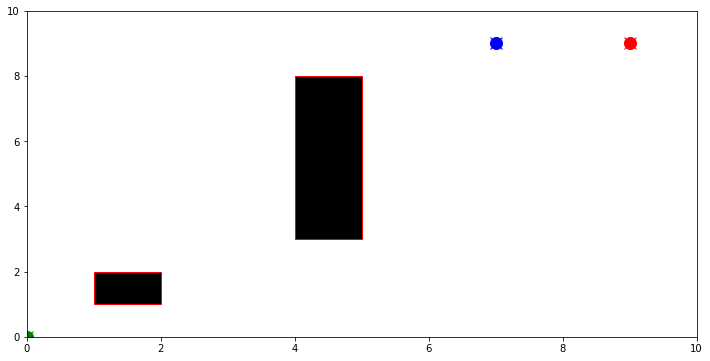

In [15]:
class dbot(object):
    """Class for defining dot represented robots"""
    def __init__(self, goal):
        self.goal = goal
        
    def get_goal(self):
        return self.goal
    
    @abstractmethod
    def get_position(self, t):
        pass

class HomonomicRobot(dbot):
    """Obstacle less holonomic robot path planner"""
    def __init__(self, init, goal, max_time):
        super().__init__(goal)
        self.init = init
        self.max_time = max_time
    
    def get_position(self, t):
        if t > self.max_time:
            return self.goal
        return (t / self.max_time) * (self.goal - self.init) + self.init
    
class BFSInstantHolonomicRobot(dbot):
    """Obstacle Avoidant BFS holonomic Robot"""
    obs = []
    step_size = 1
    def __init__(self, init, goal, **kwargs):
        super().__init__(goal)
        self.__dict__.update(kwargs)
        self.init = init  
        self.path = self.__find_path()
    
    def __get_moves(self, current_state):
        return [current_state + [[self.step_size], [0]], 
                current_state + [[-self.step_size], [0]],
                current_state + [[0], [self.step_size]],
                current_state + [[0], [-self.step_size]]]
    
    def __find_path(self):
        self.visited = [] # List to keep track of visited nodes.
        queue = []     #Initialize a queue
        self.visited.append(tuple(self.init.ravel()))
        queue.append((self.init, [tuple(self.init.ravel())]))

        while queue:
            s, path = queue.pop(0)
            if s[0] == self.goal[0] and s[1] == self.goal[1]:
                self.path = path
                return path
            for neighbour in self.__get_moves(s):
                neighbourt = tuple(neighbour.ravel())
                if neighbourt not in self.visited and not any([bool(ob.is_point_inside(neighbour)) for ob in self.obs]):
                    self.visited.append(neighbourt)
                    queue.append((neighbour, path + [neighbourt]))
            
    def get_position(self, t):
        if t >= len(self.path):
            return self.path[-1]
        return self.path[np.round(t)]
    
rect = RectangleObstacle(np.array([[4], [3]]), np.array([[5], [8]]))
rect2 = RectangleObstacle(np.array([[1], [1]]), np.array([[2], [2]]))
InstantBFSBot = BFSInstantHolonomicRobot(np.array([[3.], [4.]]), np.array([[7.], [9.]]), step_size = 0.5, obs = [rect, rect2])
InstantBFSBot2 = BFSInstantHolonomicRobot(np.array([[7.], [9.]]), np.array([[0.], [0.]]), step_size = 0.5, obs = [rect, rect2])
InstantBFSBot3 = BFSInstantHolonomicRobot(np.array([[3.], [1.]]), np.array([[9.], [9.]]), step_size = 0.5, obs = [rect, rect2])

for t in range(50):
    clear_output(wait=True)
    Frame(dbots=[InstantBFSBot, InstantBFSBot2, InstantBFSBot3], obstacles=[rect, rect2], time = t).show_frame()

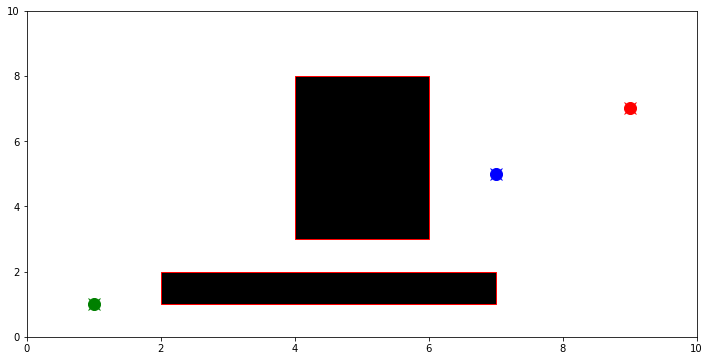

In [16]:
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self) -> bool:
        return not self.elements
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

class AStarInstantHolonomicRobot(dbot):
    """Obstacle Avoidant AStar holonomic Robot"""
    obs = []
    step_size = 1
    def __init__(self, init, goal, **kwargs):
        super().__init__(goal)
        self.__dict__.update(kwargs)
        self.init = init  
        self.path = self.__find_path()
    
    def __get_moves(self, current_state):
        moves = [[self.step_size, 0], [-self.step_size, 0], [0, self.step_size], [0, -self.step_size]]
        return [tuple(np.add(current_state, m)) for m in moves]
    
    def __heuristic(self, a, b) -> float:
        (x1, y1) = a
        (x2, y2) = b
        return abs(x1 - x2) + abs(y1 - y2)

    def __find_path(self):
        start = tuple(self.init.ravel())
        goal = tuple(self.goal.ravel())
        frontier = PriorityQueue()
        frontier.put((start, [start]), 0)
        came_from = {}
        cost_so_far = {}
        came_from[start] = None
        cost_so_far[start] = 0

        while not frontier.empty():
            current, path = frontier.get()

            if current == goal:
                self.path = path
                return path
            
            for neighbour in self.__get_moves(current):
                new_cost = cost_so_far[current] + self.step_size
                
                if neighbour not in cost_so_far or new_cost < cost_so_far[neighbour]:
                    if not any([bool(ob.is_point_inside(neighbour)) for ob in self.obs]):
                        cost_so_far[neighbour] = new_cost
                        priority = new_cost + self.__heuristic(neighbour, goal)
                        frontier.put((neighbour, path + [neighbour]), priority)
                        came_from[neighbour] = current

    def get_position(self, t):
        if t >= len(self.path):
            return self.path[-1]
        return self.path[np.round(t)]
    
rect = RectangleObstacle(np.array([[4], [3]]), np.array([[6], [8]]))
rect2 = RectangleObstacle(np.array([[7], [1]]), np.array([[2], [2]]))
InstantAStarBot = AStarInstantHolonomicRobot(np.array([[3.], [4.]]), np.array([[7.], [5.]]), step_size = 0.5, obs = [rect, rect2])
InstantAStarBot2 = AStarInstantHolonomicRobot(np.array([[7.], [9.]]), np.array([[1.], [1.]]), step_size = 0.5, obs = [rect, rect2])
InstantAStarBot3 = AStarInstantHolonomicRobot(np.array([[3.], [1.]]), np.array([[9.], [7.]]), step_size = 0.5, obs = [rect, rect2])

for t in range(50):
    clear_output(wait=True)
    Frame(dbots=[InstantAStarBot, InstantAStarBot2, InstantAStarBot3], obstacles=[rect, rect2], time = t).show_frame()

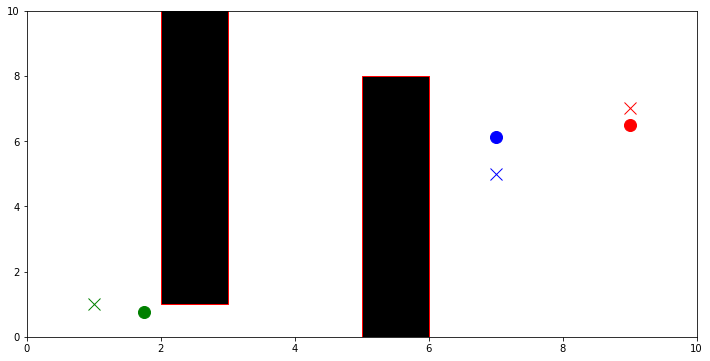

In [17]:
class AStarDynamicHolonomicRobot(dbot):
    """Obstacle Avoidant AStar holonomic Robot"""
    obs = []
    step_size = 1
    time = 0.5
    accel = (1, 1)
    max_vel = 2
    
    def __init__(self, init, goal, **kwargs):
        super().__init__(goal)
        self.__dict__.update(kwargs)
        self.init = init  
        self.path = self.__find_path()
    
    def __get_moves(self, current_state):
        current_pos = current_state[0]
        current_vel = current_state[1]
        accels = [(self.accel[0], self.accel[1]), 
             (self.accel[0], -self.accel[1]), 
             (-self.accel[0], self.accel[1]), 
             (-self.accel[0], -self.accel[1]),
             (self.accel[0], 0), 
             (-self.accel[0], 0), 
             (0, self.accel[1]), 
             (0, -self.accel[1])]
        
        v = [tuple(np.add(current_vel, np.multiply(a, self.time))) for a in accels]
        x = [tuple(np.add(current_pos, np.add(np.multiply(current_vel, self.time), np.multiply(0.5*self.time**2, a)))) for a in accels]
        return list(zip(x, v))
    
    def __heuristic(self, a, b) -> float:
        (x1, y1) = a[0]
        (x2, y2) = b[0]
        return abs(x1 - x2) + abs(y1 - y2) / self.max_vel

    def __find_path(self):
        start = tuple(self.init.ravel())
        goal = tuple(self.goal.ravel())
        frontier = PriorityQueue()
        frontier.put(((start, (0, 0)), [(start, (0, 0))]), 0)
        came_from = {}
        cost_so_far = {}
        came_from[(start, (0, 0))] = None
        cost_so_far[(start, (0, 0))] = 0

        while not frontier.empty():
            current, path = frontier.get()
            
            if current == (goal, (0, 0)):
                self.path = path
                return path
            
            for neighbour in self.__get_moves(current):
                new_cost = cost_so_far[current] + 1
                
                if neighbour not in cost_so_far or new_cost < cost_so_far[neighbour]:
                    if not any([bool(ob.is_point_inside(neighbour[0])) for ob in self.obs]):
                        cost_so_far[neighbour] = new_cost
                        priority = new_cost + self.__heuristic(neighbour, (goal, (0, 0)))
                        frontier.put((neighbour, path + [neighbour]), priority)
                        came_from[neighbour] = current

    def get_position(self, t):
        if t >= len(self.path):
            return self.path[-1][0]
        return self.path[np.round(t)][0]

rect = RectangleObstacle(np.array([[5], [0]]), np.array([[6], [8]]))
rect2 = RectangleObstacle(np.array([[2], [1]]), np.array([[3], [15]]))
DynamicAStarBot = AStarDynamicHolonomicRobot(np.array([[3.], [4.]]), np.array([[7.], [5.]]), accel = (1, 1), obs = [rect, rect2])
DynamicAStarBot2 = AStarDynamicHolonomicRobot(np.array([[7.], [9.]]), np.array([[1.], [1.]]), accel = (1, 1), obs = [rect, rect2])
DynamicAStarBot3 = AStarDynamicHolonomicRobot(np.array([[3.], [1.]]), np.array([[9.], [7.]]), accel = (1, 1), obs = [rect, rect2])

for t in range(15):
    clear_output(wait=True)
    time.sleep(0.25)
    Frame(dbots=[DynamicAStarBot, DynamicAStarBot2, DynamicAStarBot3], obstacles=[rect, rect2], time = t).show_frame()

In [18]:
class AStarDynamicHolonomicRobot(dbot):
    """Obstacle Avoidant AStar holonomic Robot"""
    obs = []
    step_size = 1
    time = 0.5
    accel = (1, 1)
    max_vel = 2
    
    def __init__(self, init, goal, **kwargs):
        super().__init__(goal)
        self.__dict__.update(kwargs)
        self.init = init  
        self.path = self.__find_path()
    
    def __get_moves(self, current_state):
        current_pos = current_state[0]
        current_vel = current_state[1]
        accels = [(self.accel[0], self.accel[1]), 
             (self.accel[0], -self.accel[1]), 
             (-self.accel[0], self.accel[1]), 
             (-self.accel[0], -self.accel[1]),
             (self.accel[0], 0), 
             (-self.accel[0], 0), 
             (0, self.accel[1]), 
             (0, -self.accel[1])]
        
        v = [tuple(np.add(current_vel, np.multiply(a, self.time))) for a in accels]
        x = [tuple(np.add(current_pos, np.add(np.multiply(current_vel, self.time), np.multiply(0.5*self.time**2, a)))) for a in accels]
        return list(zip(x, v))
    
    def __heuristic(self, a, b) -> float:
        (x1, y1) = a[0]
        (x2, y2) = b[0]
        return abs(x1 - x2) + abs(y1 - y2) / self.max_vel

    def __find_path(self):
        start = tuple(self.init.ravel())
        goal = tuple(self.goal.ravel())
        frontier = PriorityQueue()
        frontier.put(((start, (0, 0)), [(start, (0, 0))]), 0)
        came_from = {}
        cost_so_far = {}
        came_from[(start, (0, 0))] = None
        cost_so_far[(start, (0, 0))] = 0

        while not frontier.empty():
            current, path = frontier.get()
            
            if current == (goal, (0, 0)):
                self.path = path
                return path
            
            for neighbour in self.__get_moves(current):
                new_cost = cost_so_far[current] + 1
                
                if neighbour not in cost_so_far or new_cost < cost_so_far[neighbour]:
                    if not any([bool(ob.is_point_inside(neighbour[0])) for ob in self.obs]):
                        cost_so_far[neighbour] = new_cost
                        priority = new_cost + self.__heuristic(neighbour, (goal, (0, 0)))
                        frontier.put((neighbour, path + [neighbour]), priority)
                        came_from[neighbour] = current

    def get_position(self, t):
        if t >= len(self.path):
            return self.path[-1][0]
        return self.path[np.round(t)][0]

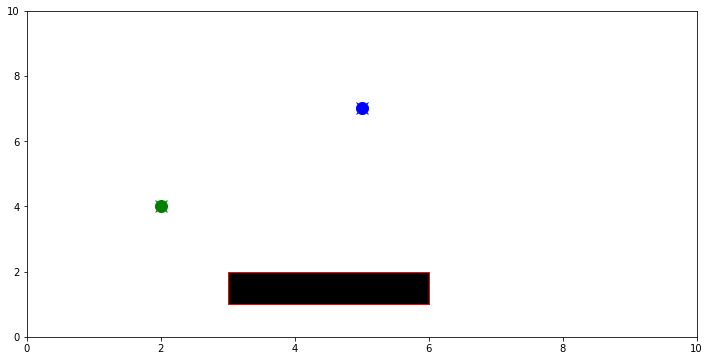

In [19]:
hol_bot = HomonomicRobot(np.array([[3.], [4.]]), np.array([[5.], [7.]]), 19)
for t in range(10):
    print(hol_bot.get_position(t))
hol_bot2 = HomonomicRobot(np.array([[8.], [9.]]), np.array([[2.], [4.]]), 13)
obs = RectangleObstacle(np.array([[3], [1]]), np.array([[6], [2]]))
f2 = Frame(dbots=[hol_bot, hol_bot2])
f2.add_obstacle(obs)
f2.show_frame()
for t in range(20):
    clear_output(wait=True)
    Frame(dbots=[hol_bot, hol_bot2], time = t).show_frame()

In [20]:
obs2 = RectangleObstacle(np.array([[4], [3]]), np.array([[5], [8]]))
l = [hol_bot2.get_position(t) for t in range(10)]
print(obs2.is_trajectory_intersected(*l), obs.is_trajectory_intersected(*l))

True False


Bot 2's velocity: (0.0, 0.0)


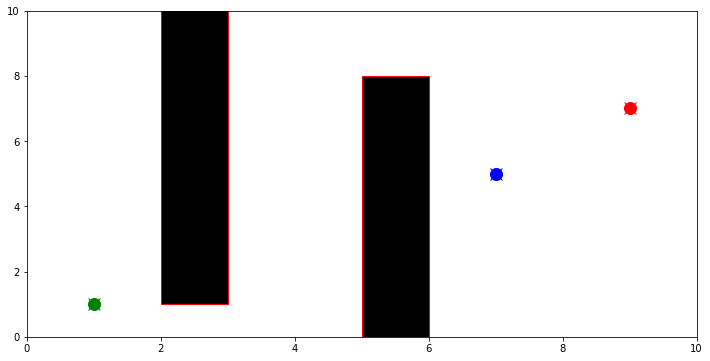

In [26]:
for t in range(18):
    clear_output(wait=True)
    time.sleep(0.25)
    print(f"Bot 2's velocity: {DynamicAStarBot2.path[t][1]}")
    Frame(dbots=[DynamicAStarBot, DynamicAStarBot2, DynamicAStarBot3], obstacles=[rect, rect2], time = t).show_frame()

In [49]:
import abc
from scipy.spatial import KDTree
from scipy.spatial.distance import minkowski
class PathPlanner(abc.ABC):
    def __init__(self, start=None, enviornment=None, **kwargs):
        super().__init__()
        self.start = np.array(start)
        self.Env = enviornment
        
    
    @abc.abstractmethod
    def find_path(self):
        pass

    @abc.abstractmethod
    def is_goal(self, state):
        """Abstract Method for defining if a state is close to the goal state."""
        pass
    
    
class Graph():
    def __init__(self, *nodes):
        self.nodes = [tuple(node) for node in nodes]
        self.parent = dict()
        self.edge = dict()
        
    def add_node(self, parent, path, child):
        child = tuple(child)
        parent = tuple(parent)
        self.nodes.append(child)
        self.parent[child] = parent
        self.edge[(parent, child)] = path
        
    def nearest_node(self, static_node, search_fn=lambda a, b: np.linalg.norm(b - a)):
        return min(self.nodes, key=lambda n: search_fn(n, static_node))
    
    def get_edge_paths(self):
        for pair in self.edge:
            yield self.edge[pair]

    def construct_path_to(self, c):
        c = tuple(c)
        return Plan.chain_paths(self.construct_path_to(self.parent[c]), self.edge[(self.parent[c], c)]) if self.parent.get(c, None) else None
    
        
class RRT(PathPlanner):
    """Class used for creating RRT paths."""
    def __init__(self, goal=None, model=None, ellipsoid=None, iterations=1000, p=2, **kwargs):
        super(RRT, self).__init__(**kwargs)
        assert model is not None
        assert goal is not None
        self.goal = np.array(goal)
        self.model = model
        self.iterations = iterations
        if ellipsoid is None:
            self.ellipsoid = np.ones_like(goal)
        else:
            self.ellipsoid = np.array(ellipsoid)
        self.plan = None
        self.p = p
    
    def nearest_node(self, node_list, static_node):
        dist_fn = lambda n: minkowski(n, static_node, p=self.p)
        node = min(node_list, key=dist_fn) 
        return dist_fn(node), node
            
    def find_path(self, time_prefix=1):
        G = Graph(self.start)
        kdTree = KDTree(np.matrix(self.start), copy_data=True)
        node_cache = [self.start]
        r_i = 1.5
        r_f = 0.01
        rate = 1/self.iterations
        for _ in range(self.iterations):
            
            q_r = self.model.get_random_state()
            
            if self.Env.in_obs(q_r[:2]):
                continue
            
            dd, ii = kdTree.query(np.matrix(q_r), p=self.p, k=1)
            dist, node = self.nearest_node(node_cache, q_r)
            
            if dist < dd[0]:
                q_n = node
            else:
                q_n = kdTree.data[ii][0]

            path_nr = self.model.local_plan(q_n, q_r)
            path_nr_truncated = path_nr.get_time_prefix((1 - rate*_) * r_i + r_f)
            
            pos_nr_truncated = path_nr_truncated.positions[:, :2]
            
            if self.Env.obs_in_path(pos_nr_truncated):
                continue
                
            q_r_truncated = path_nr_truncated.end_position()
            
            if all(q_r_truncated == q_n):
                continue
                
            G.add_node(q_n, path_nr_truncated, q_r_truncated)
            node_cache.append(q_r_truncated)
            
            if self.is_goal(q_r_truncated):
                path_r_truncated_to_goal = self.model.local_plan(q_r_truncated, self.goal)
                
                if self.Env.obs_in_path(path_r_truncated_to_goal):
                    continue
                
                print(q_r_truncated, self.goal)
                G.add_node(q_r_truncated, path_r_truncated_to_goal, self.goal)
                self.plan = G.construct_path_to(self.goal)
                return self.plan
            
            if len(node_cache) > 250:
                kdTree = KDTree(np.vstack(G.nodes), copy_data=True)
                node_cache = [node_cache[-1]]
                
            if _ % 1000 == 0:
                print(f"iter {_}")
                
                
        q_closest = G.nearest_node(self.goal, model.distance)
        self.plan = G.construct_path_to(q_closest)
        print("No Path Found")
        return None
    
    def is_goal(self, state):
        """returns a boolean describing if the input state is close to the goal state of the state space"""
        if np.all(np.abs(state - self.goal) < self.ellipsoid):
            return True
        return False

In [50]:
class StateSpace(abc.ABC):
    """State Space"""
    def __init__(self, dim=2, q_lb=[-10, -10], q_ub=[10, 10], dt=0.1, **kwargs):
        self.dim = dim
        self.q_lb = np.array(q_lb)
        self.q_ub = np.array(q_ub)
        self.dt = dt
    
    @abc.abstractmethod
    def get_random_state(self):
        """Abstract Method for generating a random state in the state space."""
        pass
    
    @staticmethod
    @abc.abstractmethod
    def distance(state_1, state_2) -> float:
        """Abstract Method for defining the distance between two states"""
        pass
    
    @abc.abstractmethod
    def local_plan(self, state_1, state_2):
        pass
        
class HolonomicStateSpace(StateSpace):
    """Holonomic State Space Model"""
    def __init__(self, velocity=3, **kwargs):
        super(HolonomicStateSpace, self).__init__(**kwargs)
        self.sec_per_meter = 1/velocity
       
    
    @staticmethod
    def distance(state_1, state_2) -> float:
        """Distance Metric"""
        return np.linalg.norm(state_2 - state_1)
    
    def get_random_state(self):
        """Generates a random state in the state space."""
        return np.random.uniform(self.q_lb, self.q_ub, size=(self.dim,))
    
    
    def local_plan(self, state_1, state_2):
        v = state_2 - state_1
        dist = np.linalg.norm(v)
        total_time = dist * self.sec_per_meter
        
        vel = v / total_time
        
        p = lambda t: state_1 + v*(t/total_time)
        
        times = np.arange(0, total_time, self.dt)
        
        states = p(times[:, np.newaxis])
        
        inputs = np.tile(vel, (states.shape[0], 1))
        plan = Plan(times, states, inputs, dt=self.dt)
        
        return plan

class HolonomicAccelStateSpace(StateSpace):
    """Holonomic State Space Model"""
    def __init__(self, accel=3, **kwargs):
        super(HolonomicAccelStateSpace, self).__init__(**kwargs)
        self.accel = accel
       
    @staticmethod
    def distance(state_1, state_2) -> float:
        """Distance Metric"""
        #Euclidian Distance
        return np.linalg.norm(state_2[:2] - state_1[:2]) + 0.5 * np.linalg.norm(state_2[2:] - state_1[2:]) ** 2
    
    def get_random_state(self):
        """Generates a random state in the state space."""
        return np.random.uniform(self.q_lb, self.q_ub, size=(self.dim,))
    
    
    def local_plan(self, state_1, state_2):
        
        x_0 = state_1[:2]
        v_0 = state_1[2:]
        sec_squared_per_meter = 1/self.accel
        
        displacement = state_2[:2] - state_1[:2]
        velocity = state_2[2:] - state_1[2:]
        
        vel_mag = np.linalg.norm(displacement)
        accel_mag = np.linalg.norm(velocity)
        
        total_time = accel_mag * sec_squared_per_meter
        
        accel = velocity / total_time
        
        p = lambda t: x_0 + v_0 * (t/total_time) + 0.5 * accel * (t/total_time) ** 2
        v = lambda t: v_0 + accel * t/total_time
        
        times = np.arange(0, total_time, self.dt)
        
        states = np.hstack((p(times[:, np.newaxis]), v(times[:, np.newaxis])))
        inputs = np.tile(accel, (states.shape[0], 1))
        plan = Plan(times, states, inputs, dt=self.dt)
        
        return plan

class Plan(object):
    def __init__(self, times, target_positions, open_loop_inputs, dt=0.01):
        self.dt = dt
        self.times = times
        self.positions = target_positions
        self.open_loop_inputs = open_loop_inputs

    def __iter__(self):
        # I have to do this in an ugly way because python2 sucks and
        # I hate it.
        for t, p, c in zip(self.times, self.positions, self.open_loop_inputs):
            yield t, p, c

    def __len__(self):
        return len(self.times)

    def get(self, t):
        """Returns the desired position and open loop input at time t.
        """
        index = int(np.sum(self.times <= t))
        index = index - 1 if index else 0
        return self.positions[index], self.open_loop_inputs[index]

    def end_position(self):
        return self.positions[-1]

    def start_position(self):
        return self.positions[0]

    def get_time_prefix(self, until_time):
        """Returns a new plan that is a prefix of this plan up until the
        time until_time.
        """
        times = self.times[self.times <= until_time]
        positions = self.positions[self.times <= until_time]
        open_loop_inputs = self.open_loop_inputs[self.times <= until_time]
        return Plan(times, positions, open_loop_inputs, self.dt)

    @classmethod
    def chain_paths(self, *paths):
        """Chain together any number of plans into a single plan.
        """
        def chain_two_paths(path1, path2):
            """Chains together two plans to create a single plan. Requires
            that path1 ends at the same configuration that path2 begins at.
            Also requires that both paths have the same discretization time
            step dt.
            """
            if not path1 and not path2:
                return None
            elif not path1:
                return path2
            elif not path2:
                return path1
            print(path1.dt, path2.dt)
            assert path1.dt == path2.dt, "Cannot append paths with different time deltas."
            # assert np.allclose(path1.end_position(), path2.start_position()), "Cannot append paths with inconsistent start and end positions."
            times = np.concatenate((path1.times, path1.times[-1] + path2.times[1:]), axis=0)
            positions = np.concatenate((path1.positions, path2.positions[1:]), axis=0)
            open_loop_inputs = np.concatenate((path1.open_loop_inputs, path2.open_loop_inputs[1:]), axis=0)
            dt = path1.dt
            return Plan(times, positions, open_loop_inputs, dt=dt)
        chained_path = None
        for path in paths:
            chained_path = chain_two_paths(chained_path, path)
        return chained_path
    
    def __repr__(self):
        return str(self.positions)

        

In [51]:
class Obstacle(object):
    """Class used to defines the structure of obstacles"""
    def __init__(self):
        super.__init__()
    
    @abstractmethod
    def is_point_inside(self, point):
        pass
    
    @abstractmethod
    def is_trajectory_intersected(self, *argv):
        pass
    
    @abstractmethod
    def plot(self, plt):
        pass

class RectangleObstacle(Obstacle):
    """Class that creates rectangle shaped objects"""
    def __init__(self, bottom_corner, top_corner):        
        self.min_x = bottom_corner[0]
        self.min_y = bottom_corner[1]
        self.max_x = top_corner[0]
        self.max_y = top_corner[1]
        
        
    def is_point_inside(self, point):
        pt_x, pt_y = point[0], point[1]
        return self.max_x >= pt_x and self.min_x <= pt_x and self.max_y >= pt_y and self.min_y <= pt_y
    
    def is_trajectory_intersected(self, trajectory):
        """Method uses disrete collision detection. Will expand to continous detection if needed -- however, we will probably just increase sample rate as needed instead."""
        return any([self.is_point_inside(point) for point in trajectory])
    
    def plot(self, plt, **kwargs):
        rectangle = plt.Rectangle((self.min_x,self.min_y), self.max_x - self.min_x,self.max_y-self.min_y, **kwargs)
        plt.gca().add_patch(rectangle)
    
    def delta_object(self, delta):
        return RectangleObstacle((self.min_x - delta, self.min_y - delta), (self.max_x + delta, self.max_y + delta))

        
    
class Environment(object):
    """Environment For simulation"""
    
    def __init__(self, dbots=[], obstacles=[], lb=(-10, -10), ub=(10, 10), **kwargs):
        self.robots = dbots
        self.obstacles = obstacles
        self.lb = lb
        self.ub = ub
    
    def add_dbot(self, dbot):
        assert type(dbot) == Dbot, "dbot must be a Dbot dawg."
        self.robots.append(dbot)
    
    def add_obstacle(self, obstacle):
        assert type(obstacle) == RectangleObstacle, "obstacle must be an Obstacle dawg."
        self.obstacles.append(obstacle)
    
    def in_obs(self, pos) -> bool:
        return any([obs.is_point_inside(pos) for obs in self.obstacles])
    
    def obs_in_path(self, path) -> bool:
        return any([obs.is_trajectory_intersected(path) for obs in self.obstacles])
    
    def get_obs_edges(self):
        l = []
        for obs in self.obstacles:
            min_x, min_y, max_x, max_y = obs.min_x, obs.min_y, obs.max_x, obs.max_y
            l.extend([(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)])
        return l
    
### world frame
class Frame(object):
    """Class for defining the frame in which obstacles and robots live."""
    
    degree = 2
    time = 0
    dbots = []
    obstacles = []
    
    def __init__(self, dbots=[], obstacles=[], delta_obs=[], lb=[0, 0], ub=[10, 10], **kwargs):
        self.__dict__.update(kwargs)
        self.dbots = dbots
        self.obstacles = obstacles
        self.delta_obs = delta_obs
        self.lb = lb
        self.ub = ub
        
    def add_dbot(self, dbot):
        assert type(dbot) == Dbot, "dbot must be a Dbot dawg."
        self.robots.append(dbot)
    
    def add_obstacle(self, obstacle):
        assert type(obstacle) == RectangleObstacle, "obstacle must be an Obstacle dawg."
        self.obstacles.append(obstacle)
        
    def show_frame(self):

        fig, ax = plt.subplots(figsize=(12, 6))
        
        cycol = cycle("bgrcmykw")
        for dbot in self.dbots:
            pos = dbot.get_position(self.time)
            goal = dbot.get_goal()
            col = next(cycol)
            ax.plot(pos[0], pos[1], color=col, marker='o', linestyle='dashed', linewidth=2, markersize=12)
            ax.plot(goal[0], goal[1], color=col, marker='x', linestyle='dashed', linewidth=2, markersize=12)
        
        for obstacle in self.obstacles:
            obstacle.plot(plt, fc='black',ec="red")
        if self.delta_obs:
            for obstacle in self.delta_obs:
                obstacle.plot(plt, linestyle='--', fill=False, ec="orange")
            
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])
        plt.show()
    
    def show_frame_with_vel(self, edges):

        def circ(x_0, y_0):
            def f(x, y):
                return ((x - x_0) ** 2 + (y - y_0) ** 2) ** 0.5   
            return f

        circle_constraints = [circ(x, y) for x, y in edges]

        def f(x, y):

            A = np.min(np.array([circle(x, y) for circle in circle_constraints]), axis = 0)
            B = np.ones_like(np.array(x))

            return np.where(A > B, A, B)

        x = np.linspace(lb[0], ub[0], 2560)
        y = np.linspace(lb[1], ub[1], 2560)
        X, Y = np.meshgrid(x, y)
        Z = f(X, Y)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        ax.contourf(X, Y, Z, 8, alpha=0.9, cmap=plt.cm.coolwarm)
        C = ax.contour(X, Y, Z, 8, colors='black', linewidth=.5)
        ax.clabel(C, inline=1, fontsize=10)
        plt.xticks(())
        plt.yticks(())
        
        cycol = cycle("bgrcmykw")
        for dbot in self.dbots:
            pos = dbot.get_position(self.time)
            goal = dbot.get_goal()
            col = next(cycol)
            ax.plot(pos[0], pos[1], color=col, marker='o', linestyle='dashed', linewidth=2, markersize=12)
            ax.plot(goal[0], goal[1], color=col, marker='x', linestyle='dashed', linewidth=2, markersize=12)
            p = dbot.get_all_positions()
            ax.plot(p[:,0], p[:,1], color=col)
        
        
        
        for obstacle in self.obstacles:
            obstacle.plot(plt, fc='black',ec="red")
        if self.delta_obs:
            for obstacle in self.delta_obs:
                obstacle.plot(plt, linestyle='--', fill=False, ec="yellow")
        
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])

        plt.show()
        

In [52]:
class dbot(object):
    """Class for defining dot represented robots"""
    def __init__(self, goal, plan):
        self.goal = goal
        self.plan = plan
        self.total_time = plan.times[-1] 
        self.dt = plan.dt
        
    def get_goal(self):
        return self.goal
    
    def get_position(self, t):
        return self.plan.get(t)[0]
    
    def get_all_positions(self):
        return self.plan.positions
    
class RRTBot(dbot):
    def __init__(self, model, start=(), goal=(), **kwargs):
        self.goal = goal
        self.model = model(**kwargs)
        self.Env = Environment(**kwargs)
        self.rrt = RRT(start=start, goal=goal, model=self.model, enviornment=self.Env, **kwargs)
        self.plan = self.rrt.find_path()
        if self.plan == None:
            self.plan = self.rrt.plan
            print(f"plan to goal, {self.goal}, not found using path to {self.plan.positions[-1]} instead")
        self.total_time = self.plan.times[-1]
        self.dt = self.plan.dt
    
    def get_position(self, t):
        return self.plan.get(t)[0]
    
    def get_all_positions(self):
        return self.plan.positions


In [55]:
rect_list = [RectangleObstacle((2, 2), (4.5, 8.5)), RectangleObstacle((5, 6), (7, 8)), RectangleObstacle((6, 3), (9, 5))] 
expanded_list = [obs.delta_object(0.5) for obs in rect_list]
lb = (-10, -10)
ub = (10, 10)

kwargs = {'velocity' : 3, 
          'dim' : 2, 
          'lb' : lb, 
          'ub' : ub,
          'q_lb' : lb,
          'q_ub' : ub,
          'dt' : 0.1, 
          'obstacles' : expanded_list, 
          'start' : (1., 1.), 
          'goal' : (8., 8.), 
          'ellipsoid' : (0.5, 0.5), 
          'iterations' : 5000}

rrtdb = RRTBot(HolonomicStateSpace, **kwargs)

for t in tqdm(np.arange(0, rrtdb.total_time + rrtdb.dt, rrtdb.dt)):
    time.sleep(rrtdb.dt)
    clear_output(wait=True)
    print(f"Bot's velocity: {rrtdb.plan.get(t)}")
    Frame(dbots=[rrtdb], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=lb, ub=ub).show_frame()
    


Bot's velocity: (array([ 1.82797348, -1.56991438]), array([ 0.91997053, -2.85546042]))


 10%|████▎                                       | 9/92 [00:02<00:21,  3.90it/s]


KeyboardInterrupt: 

Bot's velocity: (array([ 7.74211348,  7.42420721,  0.16680954, -0.07960154]), array([ 0.44344922, -2.46035623]))


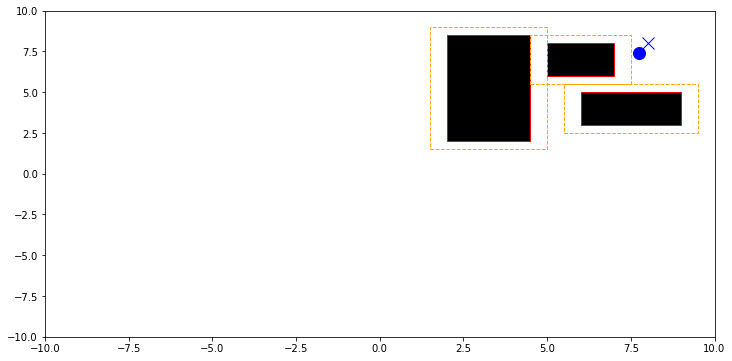

100%|███████████████████████████████████████████| 78/78 [00:18<00:00,  4.33it/s]


In [59]:
rect_list = [RectangleObstacle((2, 2), (4.5, 8.5)), RectangleObstacle((5, 6), (7, 8)), RectangleObstacle((6, 3), (9, 5))] 
expanded_list = [obs.delta_object(0.5) for obs in rect_list]

kwargs = {'accel' : 2.5, 
          'dim' : 4, 
          'lb' : (-10, -10),
          'ub' : (10, 10),
          'q_lb' : (-10, -10, -5, -5), 
          'q_ub' : (10, 10, 5, 5), 
          'dt' : 0.1, 
          'obstacles' : expanded_list, 
          'start' : (1., 1., 0., 0.), 
          'goal' : (8., 8., 0., 0.), 
          'ellipsoid' : (0.5, 0.5, 0.3, 0.3), 
          'iterations' : 20000}

rrtdb2 = RRTBot(HolonomicAccelStateSpace, **kwargs)

for t in tqdm(np.arange(0, rrtdb2.total_time + rrtdb2.dt, rrtdb2.dt)):
    time.sleep(rrtdb2.dt)
    clear_output(wait=True)
    print(f"Bot's velocity: {rrtdb2.plan.get(t)}")
    Frame(dbots=[rrtdb2], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=(-10, -10), ub=(10, 10)).show_frame()

In [ ]:
edges = enviornment.get_obs_edges()

Frame(dbots=[db], obstacles=rect_list, delta_obs=expanded_list, time = 0, lb=lb, ub=ub).show_frame_with_vel(edges)

Bot's velocity: (array([3.18048135, 9.72936667]), array([ 2.99972927, -0.04030249]))


 69%|█████████████████████████████▊             | 54/78 [00:12<00:05,  4.33it/s]


KeyboardInterrupt: 

/Users/saahilparikh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: UserWarning: The following kwargs were not used by contour: 'linewidth'


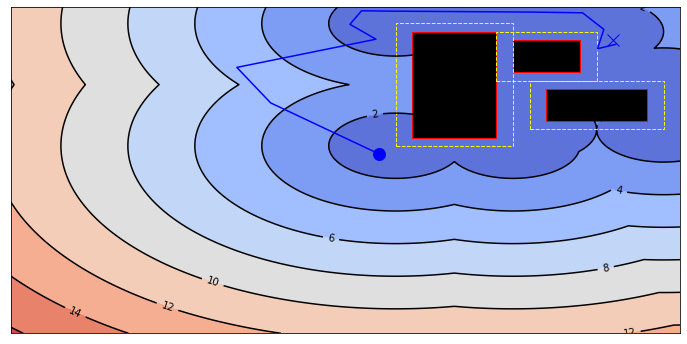

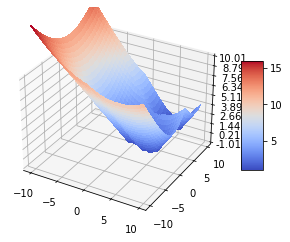

In [304]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-10, 10, 0.25)
Y = np.arange(-10, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 10.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()